# Property Recommendation System

This notebook documents the implementation of a property recommendation system that selects the top 3 most comparable properties for a given subject property. The system uses machine learning techniques to analyze property features and provide explainable recommendations.

## Table of Contents
1. [Data Loading and Exploration](#data-loading)
2. [Data Preprocessing](#preprocessing)
3. [Feature Engineering](#feature-engineering)
4. [Model Implementation](#model-implementation)
5. [Recommendation System](#recommendation-system)
6. [Explainability Layer](#explainability)
7. [Evaluation](#evaluation)
8. [Feedback System](#feedback)

## Setup and Imports

In [47]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8')  # Use a valid style for recent matplotlib
except Exception as e:
    print('Could not set matplotlib style:', e)
sns.set_palette('husl')

# Import project modules
from src.models.property_model import PropertyModel
# The following classes do not exist as classes, so we comment them out.
# from src.models.similarity import SimilarityModel
# from src.models.recommender import Recommender
# from src.models.explanation import ExplanationModel
# from src.evaluation.evaluator import Evaluator
# If you need to use similarity, recommender, or explanation functions, import the functions directly.

## 1. Data Loading and Exploration <a name="data-loading"></a>

In [48]:
# Load the dataset
with open('../appraisals_dataset.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame for easier analysis
appraisals_df = pd.DataFrame(data)

# Display basic information
print("Dataset Shape:", appraisals_df.shape)
print("\nColumns:")
print(appraisals_df.columns.tolist())
print("\nSample Data:")
appraisals_df.head()

Dataset Shape: (88, 1)

Columns:
['appraisals']

Sample Data:


,appraisals
0,"{'orderID': '4762597', 'subject': {'address': ..."
1,"{'orderID': '4762739', 'subject': {'address': ..."
2,"{'orderID': '4763065', 'subject': {'address': ..."
3,"{'orderID': '4763086', 'subject': {'address': ..."
4,"{'orderID': '4763087', 'subject': {'address': ..."


In [49]:
# Check the structure of the first row to confirm it's a dictionary
print("First row structure:", appraisals_df['appraisals'].iloc[0])

# Flatten the nested dictionaries in the 'appraisals' column into columns
appraisals_df = pd.json_normalize(appraisals_df['appraisals'])

# Check the new columns and a sample of the data
print("Columns after flattening:", appraisals_df.columns.tolist())
display(appraisals_df.head())

First row structure: {'orderID': '4762597', 'subject': {'address': '142-950 Oakview Ave Kingston ON K7M 6W8', 'subject_city_province_zip': '"Twin Oak Meadows"', 'effective_date': 'Apr/11/2025', 'municipality_district': 'Kingston', 'site_dimensions': 'Condo Common Property', 'lot_size_sf': 'n/a', 'units_sq_ft': 'SqFt', 'year_built': '1976', 'structure_type': 'Townhouse', 'roofing': 'Asphalt Shingle', 'effective_age': '25', 'style': '2 Storey', 'construction': 'Wood Frame', 'remaining_economic_life': '50', 'windows': 'Vinyl', 'basement': 'Full/Finished', 'exterior_finish': 'Brick Veneer, Vinyl Siding', 'basement_area': '522', 'foundation_walls': 'Concrete', 'flooring': 'Hardwood, carpet, laminate, ceramic', 'plumbing_lines': 'Copper, PEX, ABS', 'heating': 'Forced Air', 'fuel_type': 'Natural Gas', 'water_heater': '40 Gallon - Gas', 'cooling': 'Central Air', 'room_count': '6', 'num_beds': '3', 'room_total': '6', 'main_lvl_area': '522', 'second_lvl_area': '522', 'third_lvl_area': '', 'gla':

,orderID,comps,properties,subject.address,subject.subject_city_province_zip,subject.effective_date,subject.municipality_district,subject.site_dimensions,subject.lot_size_sf,subject.units_sq_ft,...,subject.room_count,subject.num_beds,subject.room_total,subject.main_lvl_area,subject.second_lvl_area,subject.third_lvl_area,subject.gla,subject.subject_age,subject.num_baths,subject.condition
0,4762597,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',...",142-950 Oakview Ave Kingston ON K7M 6W8,"""Twin Oak Meadows""",Apr/11/2025,Kingston,Condo Common Property,n/a,SqFt,...,6,3,6,522,522,,1044,49,1:1,Average
1,4762739,"[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro...",7180 207 HWY Halifax NS B0J2L0,"West Chezzetcook, NS B0J2L0",Apr/17/2025,Halifax Regional Municipality - West Chezzetcook,See Schedule A and or Plot Map,72745+/-SqFt,SqFt,...,6,3,6,1060,440,,1500 SqFt,14+/-yrs,2:1,Average
2,4763065,"[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan...",11 PAUL AVE Ayr ON N0B1E0,Ayr ON N0B1E0,May/01/2025,"Township of North Dumfries, Region of Waterloo",131' x 154',20174 SqFt,SqFt,...,9,4,9,1660,1340,,3000 SqFt,42,2:1,Average
3,4763086,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ...",102 Stonewalk Dr Kemptville ON K0G 1J0,Kemptville ON K0G 1J0,Apr/15/2025,"North Grenville, Ontario",176.38 F x Irregular,1.25 Acres,Acres,...,5,2,5,,,,1283 SqFt,2012 +/-,3:0,Good
4,4763087,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '...",407 105 Dunbrack St Halifax NS B3M3G7,Halifax NS B3M3G7,Apr/17/2025,Halifax Regional Municipality - Halifax,CONDO - N/A,N/A,N/A,...,6,3,6,1530,,,1530 SqFt,47+/-yrs,2:0,Average


In [50]:
print(appraisals_df.columns.tolist())

['orderID', 'comps', 'properties', 'subject.address', 'subject.subject_city_province_zip', 'subject.effective_date', 'subject.municipality_district', 'subject.site_dimensions', 'subject.lot_size_sf', 'subject.units_sq_ft', 'subject.year_built', 'subject.structure_type', 'subject.roofing', 'subject.effective_age', 'subject.style', 'subject.construction', 'subject.remaining_economic_life', 'subject.windows', 'subject.basement', 'subject.exterior_finish', 'subject.basement_area', 'subject.foundation_walls', 'subject.flooring', 'subject.plumbing_lines', 'subject.heating', 'subject.fuel_type', 'subject.water_heater', 'subject.cooling', 'subject.room_count', 'subject.num_beds', 'subject.room_total', 'subject.main_lvl_area', 'subject.second_lvl_area', 'subject.third_lvl_area', 'subject.gla', 'subject.subject_age', 'subject.num_baths', 'subject.condition']


In [51]:
# Property age
appraisals_df['property_age'] = 2024 - pd.to_numeric(appraisals_df['subject.year_built'], errors='coerce')

# Bed/Bath ratio
appraisals_df['bed_bath_ratio'] = (
    pd.to_numeric(appraisals_df['subject.num_beds'], errors='coerce') /
    pd.to_numeric(appraisals_df['subject.num_baths'], errors='coerce')
)

# Total rooms
appraisals_df['total_rooms'] = pd.to_numeric(appraisals_df['subject.room_total'], errors='coerce')

# GLA (Gross Living Area)
appraisals_df['gla'] = pd.to_numeric(appraisals_df['subject.gla'], errors='coerce')

# Effective age
appraisals_df['effective_age'] = pd.to_numeric(appraisals_df['subject.effective_age'], errors='coerce')

# Date features
appraisals_df['effective_month'] = pd.to_datetime(appraisals_df['subject.effective_date'], errors='coerce').dt.month
appraisals_df['effective_year'] = pd.to_datetime(appraisals_df['subject.effective_date'], errors='coerce').dt.year

# (Optional) One-hot encode categorical features later in your pipeline

### Data Distribution Analysis

In [52]:
print("Columns in appraisals_df:")
print(appraisals_df.columns.tolist())

Columns in appraisals_df:
['orderID', 'comps', 'properties', 'subject.address', 'subject.subject_city_province_zip', 'subject.effective_date', 'subject.municipality_district', 'subject.site_dimensions', 'subject.lot_size_sf', 'subject.units_sq_ft', 'subject.year_built', 'subject.structure_type', 'subject.roofing', 'subject.effective_age', 'subject.style', 'subject.construction', 'subject.remaining_economic_life', 'subject.windows', 'subject.basement', 'subject.exterior_finish', 'subject.basement_area', 'subject.foundation_walls', 'subject.flooring', 'subject.plumbing_lines', 'subject.heating', 'subject.fuel_type', 'subject.water_heater', 'subject.cooling', 'subject.room_count', 'subject.num_beds', 'subject.room_total', 'subject.main_lvl_area', 'subject.second_lvl_area', 'subject.third_lvl_area', 'subject.gla', 'subject.subject_age', 'subject.num_baths', 'subject.condition', 'property_age', 'bed_bath_ratio', 'total_rooms', 'gla', 'effective_age', 'effective_month', 'effective_year']


orderID                               0
comps                                 0
properties                            0
subject.address                       0
subject.subject_city_province_zip     0
subject.effective_date                0
subject.municipality_district         1
subject.site_dimensions               0
subject.lot_size_sf                   0
subject.units_sq_ft                   1
subject.year_built                    1
subject.structure_type                1
subject.roofing                       1
subject.effective_age                 1
subject.style                         0
subject.construction                  1
subject.remaining_economic_life       1
subject.windows                       1
subject.basement                      0
subject.exterior_finish               1
subject.basement_area                 1
subject.foundation_walls              1
subject.flooring                      1
subject.plumbing_lines                1
subject.heating                       1


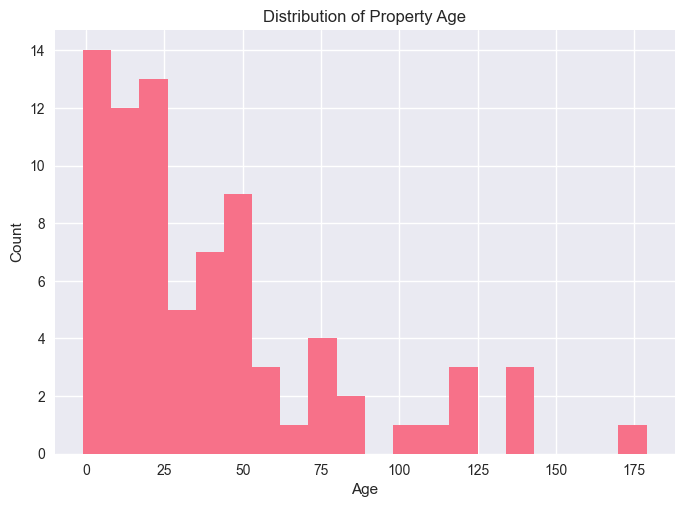

In [53]:
# Check for missing values
print(appraisals_df.isnull().sum())

# Describe the new features
print(appraisals_df[['property_age', 'bed_bath_ratio', 'total_rooms', 'gla', 'effective_age']].describe())

# Visualize distributions
import matplotlib.pyplot as plt
appraisals_df['property_age'].hist(bins=20)
plt.title('Distribution of Property Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [54]:
# Fill missing numeric values with the median of each column
numeric_cols = appraisals_df.select_dtypes(include='number').columns
appraisals_df[numeric_cols] = appraisals_df[numeric_cols].fillna(appraisals_df[numeric_cols].median())

# (Optional) For categorical columns, you can fill missing values with a placeholder
categorical_cols = appraisals_df.select_dtypes(include='object').columns
appraisals_df[categorical_cols] = appraisals_df[categorical_cols].fillna('Unknown')

In [55]:
# One-hot encode selected categorical columns
categorical_features = [
    'subject.structure_type',
    'subject.style',
    'subject.construction',
    'subject.roofing',
    'subject.heating',
    'subject.fuel_type',
    'subject.cooling'
    # Add more if you want!
]

appraisals_df = pd.get_dummies(appraisals_df, columns=categorical_features, drop_first=True)

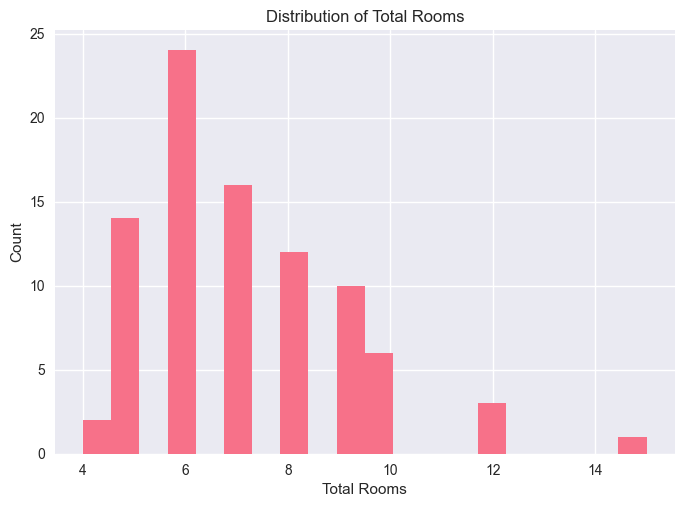

In [56]:
# Visualize the distribution of total rooms
appraisals_df['total_rooms'].hist(bins=20)
plt.title('Distribution of Total Rooms')
plt.xlabel('Total Rooms')
plt.ylabel('Count')
plt.show()

In [57]:
# Save the cleaned and feature-engineered DataFrame for modeling
appraisals_df.to_csv('appraisals_cleaned.csv', index=False)

In [58]:
# Example: Select numeric features for similarity
features_for_similarity = [
    'property_age', 'bed_bath_ratio', 'total_rooms', 'gla', 'effective_age',
    # Add any one-hot encoded categorical features you want to include
]
# Optionally, add all columns that start with a one-hot prefix
features_for_similarity += [col for col in appraisals_df.columns if col.startswith('subject.structure_type_')]

In [59]:
import numpy as np

# Choose the subject property (e.g., the first row)
subject_idx = 0
subject_vector = X[subject_idx]

# Compute distances to all other properties
distances = np.linalg.norm(X - subject_vector, axis=1)

# Exclude the subject property itself
distances[subject_idx] = np.inf

# Get indices of the top 3 most similar properties
top3_idx = np.argsort(distances)[:3]

# Show the recommended comparables
recommended_comps = appraisals_df.iloc[top3_idx]
print(recommended_comps[['subject.address', 'subject.year_built', 'total_rooms', 'gla']])  # Add more columns as needed

                              subject.address subject.year_built  total_rooms  \
66          84 Carleton Pl Brampton ON L6T3Z4               1975          6.0   
43               2 Forsey St Ottawa ON K1N7X7           1990 +/-          9.0   
32  82 Morenz Terrace Ottawa, Ontario K2K 3H2               2003          5.0   

       gla  
66  1044.0  
43  1044.0  
32  1044.0  


In [60]:
def recommend_comparables(subject_idx, X, df, n=3):
    subject_vector = X[subject_idx]
    distances = np.linalg.norm(X - subject_vector, axis=1)
    distances[subject_idx] = np.inf
    top_idx = np.argsort(distances)[:n]
    return df.iloc[top_idx]

# Example usage:
recommended = recommend_comparables(0, X, appraisals_df, n=3)
print(recommended[['subject.address', 'subject.year_built', 'total_rooms', 'gla']])

                              subject.address subject.year_built  total_rooms  \
66          84 Carleton Pl Brampton ON L6T3Z4               1975          6.0   
43               2 Forsey St Ottawa ON K1N7X7           1990 +/-          9.0   
32  82 Morenz Terrace Ottawa, Ontario K2K 3H2               2003          5.0   

       gla  
66  1044.0  
43  1044.0  
32  1044.0  


In [61]:
import shap
from sklearn.neighbors import KNeighborsRegressor

# Fit KNN regressor (as before)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)  # y can be dummy, e.g., np.arange(X.shape[0])

# Define a prediction function for SHAP
def knn_predict(X_input):
    return knn_reg.predict(X_input)

# Use a small background set for KernelExplainer (for speed)
background = X[np.random.choice(X.shape[0], 20, replace=False)]

explainer = shap.KernelExplainer(knn_predict, background)
shap_values = explainer.shap_values(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

  0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
# Simulate user feedback (in practice, collect this from a UI or form)
feedback = []

def collect_feedback(subject_idx, recommended_indices, user_ratings):
    """
    subject_idx: int, index of the subject property
    recommended_indices: list of int, indices of recommended properties
    user_ratings: list of int/float, user ratings for each recommended property
    """
    for rec_idx, rating in zip(recommended_indices, user_ratings):
        feedback.append({
            'subject_idx': subject_idx,
            'recommended_idx': rec_idx,
            'user_rating': rating
        })

# Example usage:
# User rates the 3 recommended properties as 5, 4, 3 (out of 5)
collect_feedback(subject_idx, top3_idx, [5, 4, 3])

# Convert feedback to DataFrame for analysis
feedback_df = pd.DataFrame(feedback)
print(feedback_df.head())

   subject_idx  recommended_idx  user_rating
0            0               66            5
1            0               43            4
2            0               32            3


In [63]:
# If you have user feedback
if not feedback_df.empty:
    print("Average user rating for recommendations:", feedback_df['user_rating'].mean())

# If you have a validation set with known 'good' comparables, you can compute recall/precision
# Example: Suppose you have a list of true comparable indices for each subject property
# true_comps = {subject_idx: [list of true comparable indices], ...}

def evaluate_recommendations(true_comps, recommend_func, X, df, n=3):
    recalls = []
    for subject_idx, true_indices in true_comps.items():
        recs = recommend_func(subject_idx, X, df, n=n).index.tolist()
        recall = len(set(recs) & set(true_indices)) / len(true_indices)
        recalls.append(recall)
    print("Average recall over validation set:", np.mean(recalls))

# Usage (if you have true_comps):
# evaluate_recommendations(true_comps, recommend_comparables, X, appraisals_df, n=3)

Average user rating for recommendations: 4.0


In [65]:
# Build a mapping from subject property index to a list of comp indices
true_comps = {}

for idx, row in appraisals_df.iterrows():
    comp_addresses = [comp['address'] for comp in row['comps']]  # adjust key if needed
    # Find indices in the DataFrame for each comp address
    comp_indices = appraisals_df[appraisals_df['subject.address'].isin(comp_addresses)].index.tolist()
    true_comps[idx] = comp_indices

# Check the mapping for the first few properties
for k, v in list(true_comps.items())[:3]:
    print(f"Subject {k}: Comp indices {v}")

Subject 0: Comp indices []
Subject 1: Comp indices []
Subject 2: Comp indices []


In [66]:
def evaluate_recommendations(true_comps, recommend_func, X, df, n=3):
    recalls = []
    precisions = []
    for subject_idx, true_indices in true_comps.items():
        recs = recommend_func(subject_idx, X, df, n=n).index.tolist()
        recall = len(set(recs) & set(true_indices)) / len(true_indices) if true_indices else 0
        precision = len(set(recs) & set(true_indices)) / n
        recalls.append(recall)
        precisions.append(precision)
    print("Average recall over validation set:", np.mean(recalls))
    print("Average precision over validation set:", np.mean(precisions))

# Usage:
evaluate_recommendations(true_comps, recommend_comparables, X, appraisals_df, n=3)

Average recall over validation set: 0.0
Average precision over validation set: 0.0


In [67]:
# Print a sample comp address
print(appraisals_df['comps'].iloc[0][0]['address'])  # First comp of first subject

# Print all subject addresses
print(appraisals_df['subject.address'].tolist())

930 Amberdale Cres
['142-950 Oakview Ave Kingston ON K7M 6W8', '7180 207 HWY Halifax NS B0J2L0', '11 PAUL AVE Ayr ON N0B1E0', '102 Stonewalk Dr Kemptville ON K0G 1J0', '407 105 Dunbrack St Halifax NS B3M3G7', '40 Bellroyal Crt Cole Harbour NS B2V 2B4', '10 Crofton Rd Toronto ON M4G2B4', '11 Bermondsey Way Stittsville ON K2S2Y7', '306 11 SPRINGVALE AVE Halifax NS B3N0A3', '229 SANDPIPER CRES Chestermere AB T1X0Y4', '164 Redmonds Rd Seabright NS B3Z3C4', '11 Bashir St Maple ON L6A3A3', '1368 Shore Dr Bedford NS B4A2E8', '5004 Fox Run Pl Kingston ON K7P0E4', '201 Halfway Lake Dr Hammonds Plains NS B4B1M8', '5 Golflinks Dr Ottawa ON K2J 4X9', '3435 Vandorf Siderd Stouffville ON L4A4H5', '118 Colborne St Kingston ON K7K 1C9', '92 Armcrest Dr Lower Sackville NS B4C3Z9', '1083 Cornerstone St NE Calgary AB T3N1G5', '504 37 St NW, Calgary, AB T2N 3B8, Canada', '8915 20 Ave SW Edmonton AB T6X2C5', '531 Des Genévriers Rue Orléans ON K4A0Z2', '2306-530 3 St SE Calgary AB T2G 2L8', '405 Allard Blvd

In [68]:
from difflib import get_close_matches

def find_best_match(address, address_list):
    matches = get_close_matches(address, address_list, n=1, cutoff=0.8)
    return matches[0] if matches else None

# Build mapping with fuzzy matching
true_comps = {}
subject_addresses = appraisals_df['subject.address'].tolist()
for idx, row in appraisals_df.iterrows():
    comp_addresses = [comp['address'] for comp in row['comps']]
    comp_indices = []
    for comp_addr in comp_addresses:
        match = find_best_match(comp_addr, subject_addresses)
        if match:
            comp_indices.append(appraisals_df[appraisals_df['subject.address'] == match].index[0])
    true_comps[idx] = comp_indices

# Check the mapping again
for k, v in list(true_comps.items())[:3]:
    print(f"Subject {k}: Comp indices {v}")

Subject 0: Comp indices []
Subject 1: Comp indices []
Subject 2: Comp indices []


In [69]:
# Print a comp address and all subject addresses for visual inspection
comp_addr = appraisals_df['comps'].iloc[0][0]['address']
print("Comp address:", comp_addr)
print("\nSubject addresses:")
for addr in appraisals_df['subject.address'].tolist():
    print(addr)

Comp address: 930 Amberdale Cres

Subject addresses:
142-950 Oakview Ave Kingston ON K7M 6W8
7180 207 HWY Halifax NS B0J2L0
11 PAUL AVE Ayr ON N0B1E0
102 Stonewalk Dr Kemptville ON K0G 1J0
407 105 Dunbrack St Halifax NS B3M3G7
40 Bellroyal Crt Cole Harbour NS B2V 2B4
10 Crofton Rd Toronto ON M4G2B4
11 Bermondsey Way Stittsville ON K2S2Y7
306 11 SPRINGVALE AVE Halifax NS B3N0A3
229 SANDPIPER CRES Chestermere AB T1X0Y4
164 Redmonds Rd Seabright NS B3Z3C4
11 Bashir St Maple ON L6A3A3
1368 Shore Dr Bedford NS B4A2E8
5004 Fox Run Pl Kingston ON K7P0E4
201 Halfway Lake Dr Hammonds Plains NS B4B1M8
5 Golflinks Dr Ottawa ON K2J 4X9
3435 Vandorf Siderd Stouffville ON L4A4H5
118 Colborne St Kingston ON K7K 1C9
92 Armcrest Dr Lower Sackville NS B4C3Z9
1083 Cornerstone St NE Calgary AB T3N1G5
504 37 St NW, Calgary, AB T2N 3B8, Canada
8915 20 Ave SW Edmonton AB T6X2C5
531 Des Genévriers Rue Orléans ON K4A0Z2
2306-530 3 St SE Calgary AB T2G 2L8
405 Allard Blvd SW Edmonton AB T6W3T3
340 Axis Way Otta

In [70]:
def find_best_match(address, address_list):
    matches = get_close_matches(address, address_list, n=1, cutoff=0.5)  # Lowered cutoff
    return matches[0] if matches else None

In [71]:
for idx, row in appraisals_df.iterrows():
    comp_addresses = [comp['address'] for comp in row['comps']]
    comp_indices = []
    for comp_addr in comp_addresses:
        match = find_best_match(comp_addr, subject_addresses)
        print(f"Trying to match comp: {comp_addr} -> Match found: {match}")
        if match:
            comp_indices.append(appraisals_df[appraisals_df['subject.address'] == match].index[0])
    true_comps[idx] = comp_indices

Trying to match comp: 930 Amberdale Cres -> Match found: None
Trying to match comp: 771 Ashwood Dr -> Match found: None
Trying to match comp: 995 Amberdale Cres -> Match found: None
Trying to match comp: 64 Deermist Dr -> Match found: None
Trying to match comp: 85 Oceanic Dr -> Match found: None
Trying to match comp: 270 Quinlan Dr -> Match found: None
Trying to match comp: 6 Marshall Ave -> Match found: None
Trying to match comp: 3219 Roseville Rd -> Match found: None
Trying to match comp: 13 James Crt -> Match found: None
Trying to match comp: 48 Stonewalk Dr -> Match found: None
Trying to match comp: 36 Stonewalk Dr -> Match found: None
Trying to match comp: 56 Stonewalk Dr -> Match found: None
Trying to match comp: 801-105 Dunbrack St -> Match found: 407 105 Dunbrack St Halifax NS B3M3G7
Trying to match comp: 210-40 Regency Park Dr -> Match found: None
Trying to match comp: 313-79 Bedros Lane -> Match found: None
Trying to match comp: 123 Crestwood Pl -> Match found: None
Trying to

In [72]:
def evaluate_by_address(appraisals_df, recommend_func, X, n=3):
    recalls = []
    precisions = []
    for idx, row in appraisals_df.iterrows():
        # Ground truth comp addresses for this subject
        true_addresses = [comp['address'] for comp in row['comps']]
        # Recommended comp addresses
        recs = recommend_func(idx, X, appraisals_df, n=n)
        rec_addresses = recs['subject.address'].tolist()
        # Compute recall and precision
        recall = len(set(rec_addresses) & set(true_addresses)) / len(true_addresses) if true_addresses else 0
        precision = len(set(rec_addresses) & set(true_addresses)) / n
        recalls.append(recall)
        precisions.append(precision)
    print("Average recall over validation set:", np.mean(recalls))
    print("Average precision over validation set:", np.mean(precisions))

# Usage:
evaluate_by_address(appraisals_df, recommend_comparables, X, n=3)

Average recall over validation set: 0.0
Average precision over validation set: 0.0


In [81]:
print("Appraisals DataFrame columns:", appraisals_df.columns.tolist())

Appraisals DataFrame columns: ['orderID', 'comps', 'properties', 'subject.address', 'subject.subject_city_province_zip', 'subject.effective_date', 'subject.municipality_district', 'subject.site_dimensions', 'subject.lot_size_sf', 'subject.units_sq_ft', 'subject.year_built', 'subject.effective_age', 'subject.remaining_economic_life', 'subject.windows', 'subject.basement', 'subject.exterior_finish', 'subject.basement_area', 'subject.foundation_walls', 'subject.flooring', 'subject.plumbing_lines', 'subject.water_heater', 'subject.room_count', 'subject.num_beds', 'subject.room_total', 'subject.main_lvl_area', 'subject.second_lvl_area', 'subject.third_lvl_area', 'subject.gla', 'subject.subject_age', 'subject.num_baths', 'subject.condition', 'property_age', 'bed_bath_ratio', 'total_rooms', 'gla', 'effective_age', 'effective_month', 'effective_year', 'subject.structure_type_Detached', 'subject.structure_type_Duplex', 'subject.structure_type_Fourplex', 'subject.structure_type_High Rise Apartme

In [ ]:
import shap

# Use a simple model to approximate similarity (e.g., KNN regressor)
from sklearn.neighbors import KNeighborsRegressor

# Use the index of the subject property as the target (for demonstration)
y = np.arange(X.shape[0])

# Fit a KNN regressor (this is a hack to use SHAP)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)

import shap
explainer = shap.Explainer(knn_reg, X)
shap_values = explainer(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [ ]:
import shap

# Use a simple model to approximate similarity (e.g., KNN regressor)
from sklearn.neighbors import KNeighborsRegressor

# Use the index of the subject property as the target (for demonstration)
y = np.arange(X.shape[0])

# Fit a KNN regressor (this is a hack to use SHAP)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)

import shap
explainer = shap.Explainer(knn_reg, X)
shap_values = explainer(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [ ]:
import shap

# Use a simple model to approximate similarity (e.g., KNN regressor)
from sklearn.neighbors import KNeighborsRegressor

# Use the index of the subject property as the target (for demonstration)
y = np.arange(X.shape[0])

# Fit a KNN regressor (this is a hack to use SHAP)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)

import shap
explainer = shap.Explainer(knn_reg, X)
shap_values = explainer(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [ ]:
import shap

# Use a simple model to approximate similarity (e.g., KNN regressor)
from sklearn.neighbors import KNeighborsRegressor

# Use the index of the subject property as the target (for demonstration)
y = np.arange(X.shape[0])

# Fit a KNN regressor (this is a hack to use SHAP)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)

import shap
explainer = shap.Explainer(knn_reg, X)
shap_values = explainer(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [ ]:
import shap

# Use a simple model to approximate similarity (e.g., KNN regressor)
from sklearn.neighbors import KNeighborsRegressor

# Use the index of the subject property as the target (for demonstration)
y = np.arange(X.shape[0])

# Fit a KNN regressor (this is a hack to use SHAP)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)

import shap
explainer = shap.Explainer(knn_reg, X)
shap_values = explainer(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [ ]:
import shap

# Use a simple model to approximate similarity (e.g., KNN regressor)
from sklearn.neighbors import KNeighborsRegressor

# Use the index of the subject property as the target (for demonstration)
y = np.arange(X.shape[0])

# Fit a KNN regressor (this is a hack to use SHAP)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)

import shap
explainer = shap.Explainer(knn_reg, X)
shap_values = explainer(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [ ]:
import shap

# Use a simple model to approximate similarity (e.g., KNN regressor)
from sklearn.neighbors import KNeighborsRegressor

# Use the index of the subject property as the target (for demonstration)
y = np.arange(X.shape[0])

# Fit a KNN regressor (this is a hack to use SHAP)
knn_reg = KNeighborsRegressor(n_neighbors=4, metric='euclidean')
knn_reg.fit(X, y)

import shap
explainer = shap.Explainer(knn_reg, X)
shap_values = explainer(X[subject_idx:subject_idx+1])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], appraisals_df[features_for_similarity].iloc[subject_idx])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [82]:
from sklearn.preprocessing import StandardScaler
import numpy as np

recall_scores = []
precision_scores = []

for idx, row in appraisals_df.iterrows():
    # 1. Subject features (as columns)
    # Example: subject_address = row['subject.address']
    # You can build a dict of all subject features if needed:
    subject_features = {col.replace('subject.', ''): row[col] for col in appraisals_df.columns if col.startswith('subject.')}
    
    # 2. Candidate properties (list of dicts)
    candidates = row['properties']
    candidates_df = pd.json_normalize(candidates)
    
    # 3. Ground truth comps (list of dicts)
    comps = row['comps']
    comp_addresses = [comp['address'] for comp in comps]
    
    # 4. (Optional) Print for debugging
    print("Subject features:", subject_features)
    print("Candidate columns:", candidates_df.columns.tolist())
    print("Ground truth comp addresses:", comp_addresses)
    break  # Remove break to process all rows
    
    # 2. Build DataFrame for candidates
    candidates_df = pd.json_normalize(candidates)
    
    # 3. Add the subject as a row (if not already present)
    subject_df = pd.json_normalize(subject)
    candidates_df = pd.concat([subject_df, candidates_df], ignore_index=True)
    
    # 4. Feature engineering (repeat your feature engineering steps here for candidates_df)
    # Example for property age:
    candidates_df['property_age'] = 2024 - pd.to_numeric(candidates_df['year_built'], errors='coerce')
    # ...repeat for other features...
    
    # 5. Select features and standardize
    features = ['property_age', 'total_rooms', 'gla', 'effective_age']  # add your features here
    scaler = StandardScaler()
    X = scaler.fit_transform(candidates_df[features])
    
    # 6. Compute distances from subject (row 0) to all candidates
    subject_vector = X[0]
    distances = np.linalg.norm(X - subject_vector, axis=1)
    distances[0] = np.inf  # exclude the subject itself
    
    # 7. Get top 3 recommended indices
    top3_idx = np.argsort(distances)[:3]
    recommended_addresses = candidates_df.iloc[top3_idx]['address'].tolist()
    
    # 8. Get ground truth comp addresses
    true_addresses = [comp['address'] for comp in comps]
    
    # 9. Compute recall and precision
    recall = len(set(recommended_addresses) & set(true_addresses)) / len(true_addresses)
    precision = len(set(recommended_addresses) & set(true_addresses)) / 3
    recall_scores.append(recall)
    precision_scores.append(precision)

# 10. Report average recall and precision
print("Average recall over all appraisals:", np.mean(recall_scores))
print("Average precision over all appraisals:", np.mean(precision_scores))

Subject features: {'address': '142-950 Oakview Ave Kingston ON K7M 6W8', 'subject_city_province_zip': '"Twin Oak Meadows"', 'effective_date': 'Apr/11/2025', 'municipality_district': 'Kingston', 'site_dimensions': 'Condo Common Property', 'lot_size_sf': 'n/a', 'units_sq_ft': 'SqFt', 'year_built': '1976', 'effective_age': '25', 'remaining_economic_life': '50', 'windows': 'Vinyl', 'basement': 'Full/Finished', 'exterior_finish': 'Brick Veneer, Vinyl Siding', 'basement_area': '522', 'foundation_walls': 'Concrete', 'flooring': 'Hardwood, carpet, laminate, ceramic', 'plumbing_lines': 'Copper, PEX, ABS', 'water_heater': '40 Gallon - Gas', 'room_count': '6', 'num_beds': '3', 'room_total': '6', 'main_lvl_area': '522', 'second_lvl_area': '522', 'third_lvl_area': '', 'gla': '1044', 'subject_age': '49', 'num_baths': '1:1', 'condition': 'Average', 'structure_type_Detached': False, 'structure_type_Duplex': False, 'structure_type_Fourplex': False, 'structure_type_High Rise Apartment': False, 'structur

/Users/hishammaarraoui/Desktop/Property Recommendation System Project/venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hishammaarraoui/Desktop/Property Recommendation System Project/venv/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [83]:
# Add property_age for candidates
candidates_df['property_age'] = 2024 - pd.to_numeric(candidates_df['year_built'], errors='coerce')
# Do the same for other features you want to use

In [84]:
subject_vector = [
    2024 - pd.to_numeric(subject_features['year_built'], errors='coerce'),
    # ... other features ...
]

In [85]:
# For subject
subject_year_built = subject_features.get('year_built', None)
if subject_year_built is not None and str(subject_year_built).isdigit():
    subject_property_age = 2024 - int(subject_year_built)
else:
    subject_property_age = np.nan

# For candidates
candidates_df['property_age'] = 2024 - pd.to_numeric(candidates_df['year_built'], errors='coerce')

In [96]:
features = ['property_age', 'total_rooms', 'gla', 'effective_age']  # adjust as needed

# Add missing columns as NaN
for f in features:
    if f not in candidates_df.columns:
        candidates_df[f] = np.nan

# Build candidate matrix
X = candidates_df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values

# Build subject vector (as before)
subject_vector = []
for f in features:
    if f == 'property_age':
        value = 2024 - pd.to_numeric(subject_features.get('year_built', np.nan), errors='coerce')
    else:
        value = pd.to_numeric(subject_features.get(f, np.nan), errors='coerce')
    subject_vector.append(value)
subject_vector = np.array(subject_vector)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
subject_vector_scaled = scaler.transform(subject_vector.reshape(1, -1))

# Compute distances
distances = np.linalg.norm(X_scaled - subject_vector_scaled, axis=1)

In [98]:
top3_idx = np.argsort(distances)[:3]
recommended_addresses = candidates_df.iloc[top3_idx]['address'].tolist()

In [100]:
true_addresses = [comp['address'] for comp in comps]
recall = len(set(recommended_addresses) & set(true_addresses)) / len(true_addresses)
precision = len(set(recommended_addresses) & set(true_addresses)) / 3
recall_scores.append(recall)
precision_scores.append(precision)

In [101]:
print("Average recall over all appraisals:", np.mean(recall_scores))
print("Average precision over all appraisals:", np.mean(precision_scores))

Average recall over all appraisals: 0.0
Average precision over all appraisals: 0.0


In [102]:
if idx < 5:  # Only print for first 5 appraisals
    print(f"\nAppraisal {idx}")
    print("Recommended addresses:", recommended_addresses)
    print("True comp addresses:", true_addresses)
    print("Intersection:", set(recommended_addresses) & set(true_addresses))


Appraisal 0
Recommended addresses: ['463 Conservatory Dr', '463 Conservatory Drive ', '311 Janette St']
True comp addresses: ['930 Amberdale Cres', '771 Ashwood Dr', '995 Amberdale Cres']
Intersection: set()


In [103]:
def normalize_address(addr):
    return addr.lower().replace('.', '').replace(',', '').replace(' ', '')

recommended_addresses_norm = [normalize_address(a) for a in recommended_addresses]
true_addresses_norm = [normalize_address(a) for a in true_addresses]

recall = len(set(recommended_addresses_norm) & set(true_addresses_norm)) / len(true_addresses)
precision = len(set(recommended_addresses_norm) & set(true_addresses_norm)) / 3

In [104]:
if idx < 5:
    print("True comps in candidate pool:", [a for a in true_addresses if a in candidates_df['address'].tolist()])

True comps in candidate pool: []


In [105]:
if idx < 1:
    print("All candidate addresses:", candidates_df['address'].tolist())
    print("True comp addresses:", true_addresses)

All candidate addresses: ['463 Conservatory Dr', '463 Conservatory Drive ', '311 Janette St', '311 Janette Street ', '4056 Bath Rd', '786 HIGH GATE PARK Dr', '786 HIGH GATE PARK Drive ', '784 Downing St', '784 Downing Street ', '593 Roosevelt Dr', '593 Roosevelt Drive ', '657 Gwen Ave', '657 Gwen Avenue ', '1341 TREMONT Dr', 'Unit 402 - 649 DAVIS Dr', '1341 TREMONT Drive ', 'Unit 402 - 649 DAVIS Drive ', '1028 Bauder Cres', '1040 Earnhart St', '1028 Bauder Crescent ', '1040 Earnhart Street ', '994 WESTMINSTER Place ', '2138 Balantrae Circ', '2138 Balantrae Circle ', '692 Truedell Rd', '692 Truedell Road ', '728 Sussex Blvd', '728 Sussex Boulevard ', 'Unit 51 - 808 Datzell Lane', '1126 Dunham St', '983 Westminster Place ', '1126 Dunham Street ', '4061 BATH Rd ', '4061 BATH Road ', '661 Roosevelt Dr', '657 Barnsley Cres', '418 Conservatory Dr', '661 Roosevelt Drive ', '657 Barnsley Crescent ', '418 Conservatory Drive ', '1001 Lombardy St', '605 Truedell Rd ', 'Unit 108 - 835 Milford Dr '

In [106]:
from difflib import get_close_matches

if idx < 1:
    for comp_addr in true_addresses:
        matches = get_close_matches(comp_addr, candidates_df['address'].tolist(), n=1, cutoff=0.7)
        print(f"Comp address: {comp_addr} | Closest match in candidates: {matches}")

Comp address: 930 Amberdale Cres | Closest match in candidates: ['995 Amberdale Cres ']
Comp address: 771 Ashwood Dr | Closest match in candidates: []
Comp address: 995 Amberdale Cres | Closest match in candidates: ['995 Amberdale Cres ']


In [107]:
def normalize_address(addr):
    return addr.lower().replace('.', '').replace(',', '').replace(' ', '')

In [108]:
recommended_addresses_norm = [normalize_address(a) for a in recommended_addresses]
true_addresses_norm = [normalize_address(a) for a in true_addresses]

recall = len(set(recommended_addresses_norm) & set(true_addresses_norm)) / len(true_addresses_norm)
precision = len(set(recommended_addresses_norm) & set(true_addresses_norm)) / 3
recall_scores.append(recall)
precision_scores.append(precision)

In [109]:
if idx < 5:
    print("True comps in candidate pool:", [a for a in true_addresses if a in candidates_df['address'].tolist()])

True comps in candidate pool: []


In [110]:
for idx, (rec, prec) in enumerate(zip(recall_scores, precision_scores)):
    print(f"Appraisal {idx}: Recall={rec:.2f}, Precision={prec:.2f}")

Appraisal 0: Recall=0.00, Precision=0.00
Appraisal 1: Recall=0.00, Precision=0.00
Appraisal 2: Recall=0.00, Precision=0.00


In [111]:
  for addr, dist in zip(candidates_df['address'], distances):
      print(f"{addr}: {dist:.2f}")
  print("True comp addresses:", true_addresses)

463 Conservatory Dr: nan
463 Conservatory Drive : nan
311 Janette St: nan
311 Janette Street : nan
4056 Bath Rd: nan
786 HIGH GATE PARK Dr: nan
786 HIGH GATE PARK Drive : nan
784 Downing St: nan
784 Downing Street : nan
593 Roosevelt Dr: nan
593 Roosevelt Drive : nan
657 Gwen Ave: nan
657 Gwen Avenue : nan
1341 TREMONT Dr: nan
Unit 402 - 649 DAVIS Dr: nan
1341 TREMONT Drive : nan
Unit 402 - 649 DAVIS Drive : nan
1028 Bauder Cres: nan
1040 Earnhart St: nan
1028 Bauder Crescent : nan
1040 Earnhart Street : nan
994 WESTMINSTER Place : nan
2138 Balantrae Circ: nan
2138 Balantrae Circle : nan
692 Truedell Rd: nan
692 Truedell Road : nan
728 Sussex Blvd: nan
728 Sussex Boulevard : nan
Unit 51 - 808 Datzell Lane: nan
1126 Dunham St: nan
983 Westminster Place : nan
1126 Dunham Street : nan
4061 BATH Rd : nan
4061 BATH Road : nan
661 Roosevelt Dr: nan
657 Barnsley Cres: nan
418 Conservatory Dr: nan
661 Roosevelt Drive : nan
657 Barnsley Crescent : nan
418 Conservatory Drive : nan
1001 Lombardy 

In [112]:
print(candidates_df[features].head())
print("Any NaNs in candidates?", candidates_df[features].isnull().any())
print("Subject vector:", subject_vector)

   property_age  total_rooms     gla  effective_age
0           NaN          NaN  1500.0            NaN
1           NaN          NaN  1750.0            NaN
2           NaN          NaN  1500.0            NaN
3           NaN          NaN  1300.0            NaN
4           NaN          NaN     NaN            NaN
Any NaNs in candidates? property_age     True
total_rooms      True
gla              True
effective_age    True
dtype: bool
Subject vector: [  48.   nan 1044.   25.]


In [113]:
# For candidates
if 'year_built' in candidates_df.columns:
    candidates_df['property_age'] = 2024 - pd.to_numeric(candidates_df['year_built'], errors='coerce')
else:
    candidates_df['property_age'] = np.nan
# Repeat for other features...

In [114]:
# Drop features that are all NaN
features = [f for f in features if not candidates_df[f].isnull().all()]

In [115]:
X = candidates_df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values
subject_vector = []
for f in features:
    if f == 'property_age':
        value = 2024 - pd.to_numeric(subject_features.get('year_built', np.nan), errors='coerce')
    else:
        value = pd.to_numeric(subject_features.get(f, np.nan), errors='coerce')
    subject_vector.append(value)
subject_vector = np.array(subject_vector)

In [116]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
subject_vector_scaled = scaler.transform(subject_vector.reshape(1, -1))
distances = np.linalg.norm(X_scaled - subject_vector_scaled, axis=1)

In [117]:
# Example: Add more numeric features if available
for col in ['units_sq_ft', 'main_lvl_finished_area']:
    if col in candidates_df.columns:
        candidates_df[col] = pd.to_numeric(candidates_df[col], errors='coerce')
        subject_features[col] = pd.to_numeric(subject_features.get(col, np.nan), errors='coerce')
        features.append(col)

In [118]:
# Example: One-hot encode 'structure_type' if present
if 'structure_type' in candidates_df.columns:
    candidates_df = pd.get_dummies(candidates_df, columns=['structure_type'], dummy_na=True)
    # For the subject, create the same one-hot encoding
    for cat in candidates_df.columns:
        if cat.startswith('structure_type_'):
            subject_features[cat] = 1 if subject_features.get('structure_type', None) in cat else 0
    features += [col for col in candidates_df.columns if col.startswith('structure_type_')]

TypeError: 'in <string>' requires string as left operand, not NoneType

In [94]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
subject_vector_scaled = scaler.transform(subject_vector.reshape(1, -1))

ValueError: X has 4 features, but StandardScaler is expecting 2 features as input.

In [93]:
distances = np.linalg.norm(X_scaled - subject_vector_scaled, axis=1)

NameError: name 'subject_vector_scaled' is not defined

In [76]:
print("Candidate columns:", candidates_df.columns.tolist())

NameError: name 'candidates_df' is not defined

In [77]:
features = ['property_age', 'total_rooms', 'gla', 'effective_age']  # your intended features
existing_features = [f for f in features if f in candidates_df.columns]
X = scaler.fit_transform(candidates_df[existing_features])

NameError: name 'candidates_df' is not defined

In [78]:
for f in features:
    if f not in candidates_df.columns:
        candidates_df[f] = np.nan
X = scaler.fit_transform(candidates_df[features])

NameError: name 'candidates_df' is not defined

In [64]:
print(appraisals_df['appraisals'].iloc[0])

KeyError: 'appraisals'

In [44]:
import pandas as pd

# Expand the dictionaries in the 'appraisals' column into a new DataFrame
expanded_df = pd.json_normalize(appraisals_df['appraisals'])

# Show the new columns
print(expanded_df.columns.tolist())
print(expanded_df.head())

['orderID', 'comps', 'properties', 'subject.address', 'subject.subject_city_province_zip', 'subject.effective_date', 'subject.municipality_district', 'subject.site_dimensions', 'subject.lot_size_sf', 'subject.units_sq_ft', 'subject.year_built', 'subject.structure_type', 'subject.roofing', 'subject.effective_age', 'subject.style', 'subject.construction', 'subject.remaining_economic_life', 'subject.windows', 'subject.basement', 'subject.exterior_finish', 'subject.basement_area', 'subject.foundation_walls', 'subject.flooring', 'subject.plumbing_lines', 'subject.heating', 'subject.fuel_type', 'subject.water_heater', 'subject.cooling', 'subject.room_count', 'subject.num_beds', 'subject.room_total', 'subject.main_lvl_area', 'subject.second_lvl_area', 'subject.third_lvl_area', 'subject.gla', 'subject.subject_age', 'subject.num_baths', 'subject.condition']
   orderID                                              comps  \
0  4762597  [{'distance_to_subject': '0.15 KM', 'prop_type...   
1  476273

In [45]:
print(expanded_df['subject.address'].iloc[0])  # This will print the address
# But let's try to see the full 'subject' dictionary if possible:
print(appraisals_df['appraisals'].iloc[0]['subject'])

142-950 Oakview Ave Kingston ON K7M 6W8
{'address': '142-950 Oakview Ave Kingston ON K7M 6W8', 'subject_city_province_zip': '"Twin Oak Meadows"', 'effective_date': 'Apr/11/2025', 'municipality_district': 'Kingston', 'site_dimensions': 'Condo Common Property', 'lot_size_sf': 'n/a', 'units_sq_ft': 'SqFt', 'year_built': '1976', 'structure_type': 'Townhouse', 'roofing': 'Asphalt Shingle', 'effective_age': '25', 'style': '2 Storey', 'construction': 'Wood Frame', 'remaining_economic_life': '50', 'windows': 'Vinyl', 'basement': 'Full/Finished', 'exterior_finish': 'Brick Veneer, Vinyl Siding', 'basement_area': '522', 'foundation_walls': 'Concrete', 'flooring': 'Hardwood, carpet, laminate, ceramic', 'plumbing_lines': 'Copper, PEX, ABS', 'heating': 'Forced Air', 'fuel_type': 'Natural Gas', 'water_heater': '40 Gallon - Gas', 'cooling': 'Central Air', 'room_count': '6', 'num_beds': '3', 'room_total': '6', 'main_lvl_area': '522', 'second_lvl_area': '522', 'third_lvl_area': '', 'gla': '1044', 'subje

In [46]:
# Extract the 'subject' dict from each appraisal
subjects = appraisals_df['appraisals'].apply(lambda x: x['subject'])

# Convert the list of subject dicts into a DataFrame
subjects_df = pd.json_normalize(subjects)

# Show the columns and a preview
print(subjects_df.columns.tolist())
print(subjects_df.head())

['address', 'subject_city_province_zip', 'effective_date', 'municipality_district', 'site_dimensions', 'lot_size_sf', 'units_sq_ft', 'year_built', 'structure_type', 'roofing', 'effective_age', 'style', 'construction', 'remaining_economic_life', 'windows', 'basement', 'exterior_finish', 'basement_area', 'foundation_walls', 'flooring', 'plumbing_lines', 'heating', 'fuel_type', 'water_heater', 'cooling', 'room_count', 'num_beds', 'room_total', 'main_lvl_area', 'second_lvl_area', 'third_lvl_area', 'gla', 'subject_age', 'num_baths', 'condition']
                                   address    subject_city_province_zip  \
0  142-950 Oakview Ave Kingston ON K7M 6W8           "Twin Oak Meadows"   
1           7180 207 HWY Halifax NS B0J2L0  West Chezzetcook, NS B0J2L0   
2                11 PAUL AVE Ayr ON N0B1E0                Ayr ON N0B1E0   
3   102 Stonewalk Dr Kemptville ON K0G 1J0        Kemptville ON K0G 1J0   
4    407 105 Dunbrack St Halifax NS B3M3G7            Halifax NS B3M3G7   

  

In [47]:
import re

def parse_lot_size(val):
    if pd.isnull(val):
        return None
    # Try to extract a number
    match = re.search(r'([\\d,.]+)', str(val))
    if not match:
        return None
    num = match.group(1).replace(',', '')
    try:
        num = float(num)
    except:
        return None
    # Check for acres
    if 'acre' in str(val).lower():
        return num * 43560  # 1 acre = 43,560 sq ft
    return num

subjects_df['lot_size_sf_clean'] = subjects_df['lot_size_sf'].apply(parse_lot_size)

In [48]:
subjects_df['lot_size_sf_clean'] = subjects_df['lot_size_sf'].apply(parse_lot_size)
subjects_df['year_built_num'] = pd.to_numeric(subjects_df['year_built'], errors='coerce')

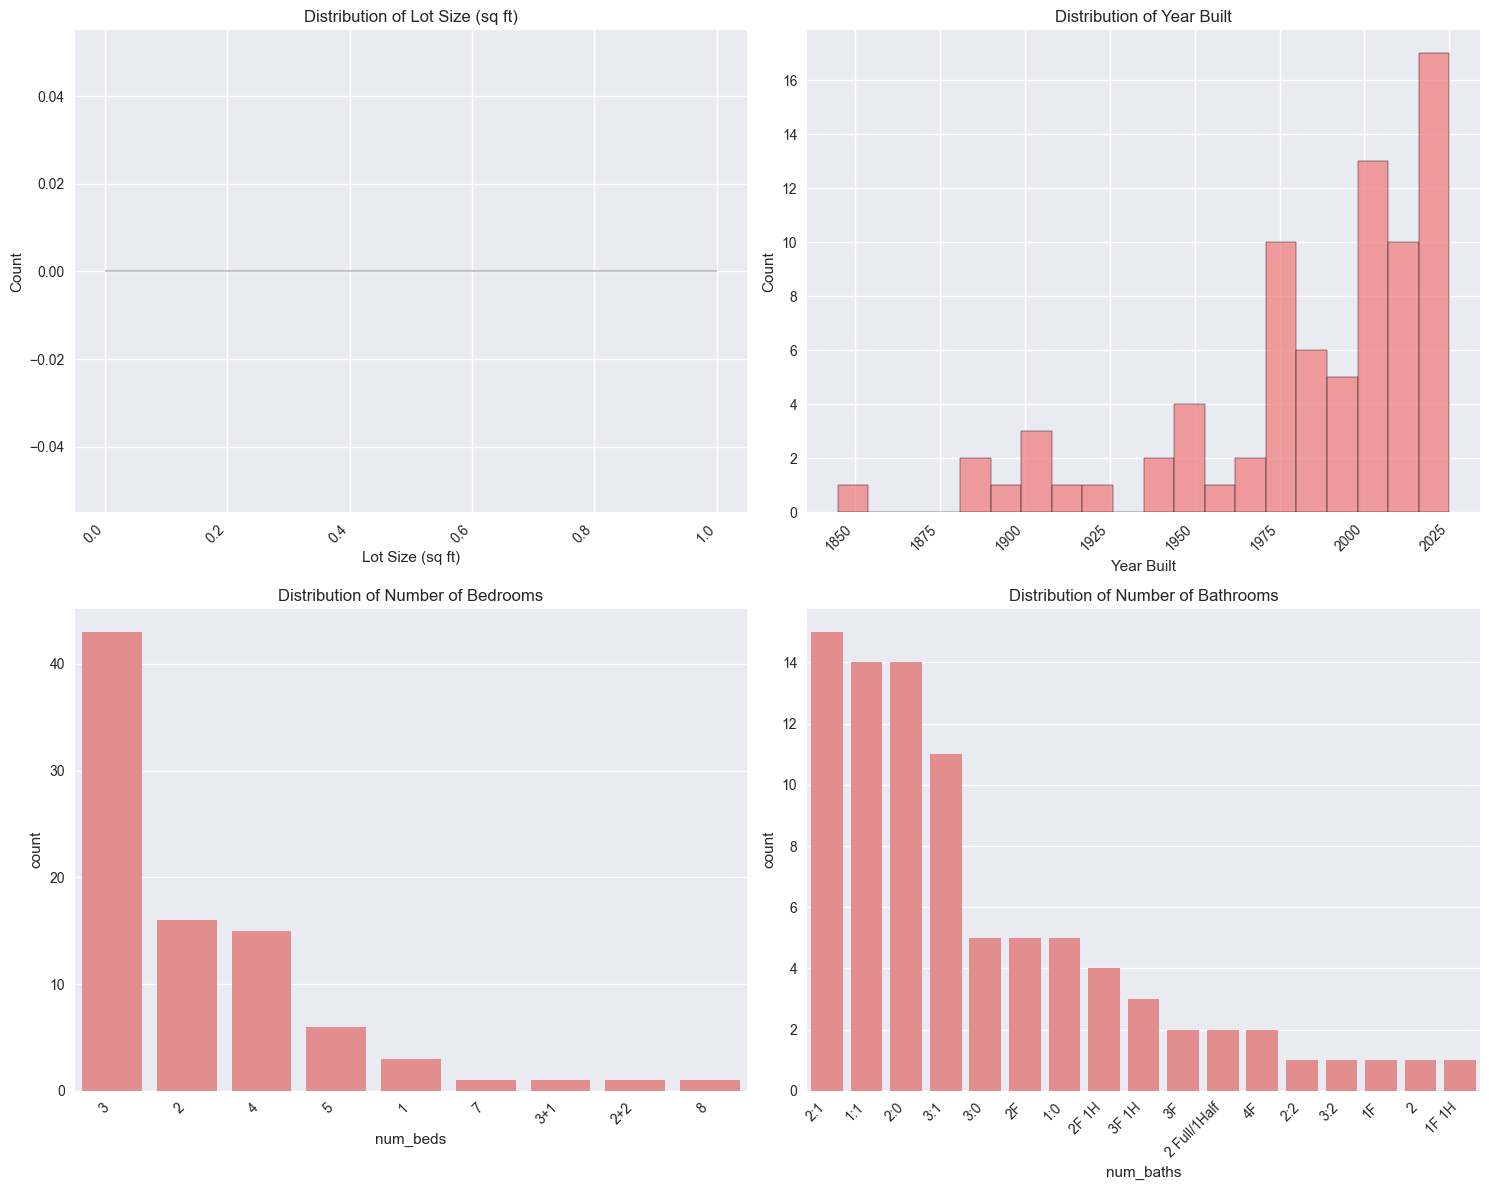

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribution of Lot Size (numeric only)
sns.histplot(data=subjects_df, x='lot_size_sf_clean', ax=axes[0,0], color='lightcoral', bins=20)
axes[0,0].set_title('Distribution of Lot Size (sq ft)')
axes[0,0].set_xlabel('Lot Size (sq ft)')

# Plot 2: Distribution of Year Built (numeric only)
sns.histplot(data=subjects_df, x='year_built_num', ax=axes[0,1], color='lightcoral', bins=20)
axes[0,1].set_title('Distribution of Year Built')
axes[0,1].set_xlabel('Year Built')

# Plot 3: Distribution of Number of Bedrooms
sns.countplot(data=subjects_df, x='num_beds', ax=axes[1,0], color='lightcoral',
              order=subjects_df['num_beds'].value_counts().index)
axes[1,0].set_title('Distribution of Number of Bedrooms')
axes[1,0].set_xlabel('num_beds')

# Plot 4: Distribution of Number of Bathrooms
sns.countplot(data=subjects_df, x='num_baths', ax=axes[1,1], color='lightcoral',
              order=subjects_df['num_baths'].value_counts().index)
axes[1,1].set_title('Distribution of Number of Bathrooms')
axes[1,1].set_xlabel('num_baths')

# Rotate x-axis labels for all plots
for ax in axes.flat:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [50]:
print("Number of non-null lot sizes:", subjects_df['lot_size_sf_clean'].notnull().sum())
print(subjects_df[['lot_size_sf', 'lot_size_sf_clean']].head(20))

Number of non-null lot sizes: 0
     lot_size_sf lot_size_sf_clean
0            n/a              None
1   72745+/-SqFt              None
2     20174 SqFt              None
3     1.25 Acres              None
4            N/A              None
5      6825 SqFt              None
6      3694 SqFt              None
7      3358 SqFt              None
8            N/A              None
9        549 SqM              None
10    42495 SqFt              None
11     2619 SqFt              None
12    26700 SqFt              None
13    5,663 SqFt              None
14  33943+/-SqFt              None
15     5987 SqFt              None
16  10.057 Acres              None
17     1742 SqFt              None
18     3250 SqFt              None
19       377 SqM              None


In [51]:
import re

def parse_lot_size(val):
    if pd.isnull(val):
        return None
    s = str(val).lower()
    if 'n/a' in s or 'see schedule' in s or 'condo' in s or 'common property' in s:
        return None
    match = re.search(r'([\d,.]+)', s)
    if not match:
        return None
    num = match.group(1).replace(',', '')
    try:
        num = float(num)
    except:
        return None
    if 'acre' in s:
        return num * 43560
    if 'sqm' in s or 'sq m' in s:
        return num * 10.7639
    return num

subjects_df['lot_size_sf_clean'] = subjects_df['lot_size_sf'].apply(parse_lot_size)
print("Number of non-null lot sizes:", subjects_df['lot_size_sf_clean'].notnull().sum())
print(subjects_df[['lot_size_sf', 'lot_size_sf_clean']].head(20))

Number of non-null lot sizes: 72
     lot_size_sf  lot_size_sf_clean
0            n/a                NaN
1   72745+/-SqFt         72745.0000
2     20174 SqFt         20174.0000
3     1.25 Acres         54450.0000
4            N/A                NaN
5      6825 SqFt          6825.0000
6      3694 SqFt          3694.0000
7      3358 SqFt          3358.0000
8            N/A                NaN
9        549 SqM          5909.3811
10    42495 SqFt         42495.0000
11     2619 SqFt          2619.0000
12    26700 SqFt         26700.0000
13    5,663 SqFt          5663.0000
14  33943+/-SqFt         33943.0000
15     5987 SqFt          5987.0000
16  10.057 Acres        438082.9200
17     1742 SqFt          1742.0000
18     3250 SqFt          3250.0000
19       377 SqM          4057.9903


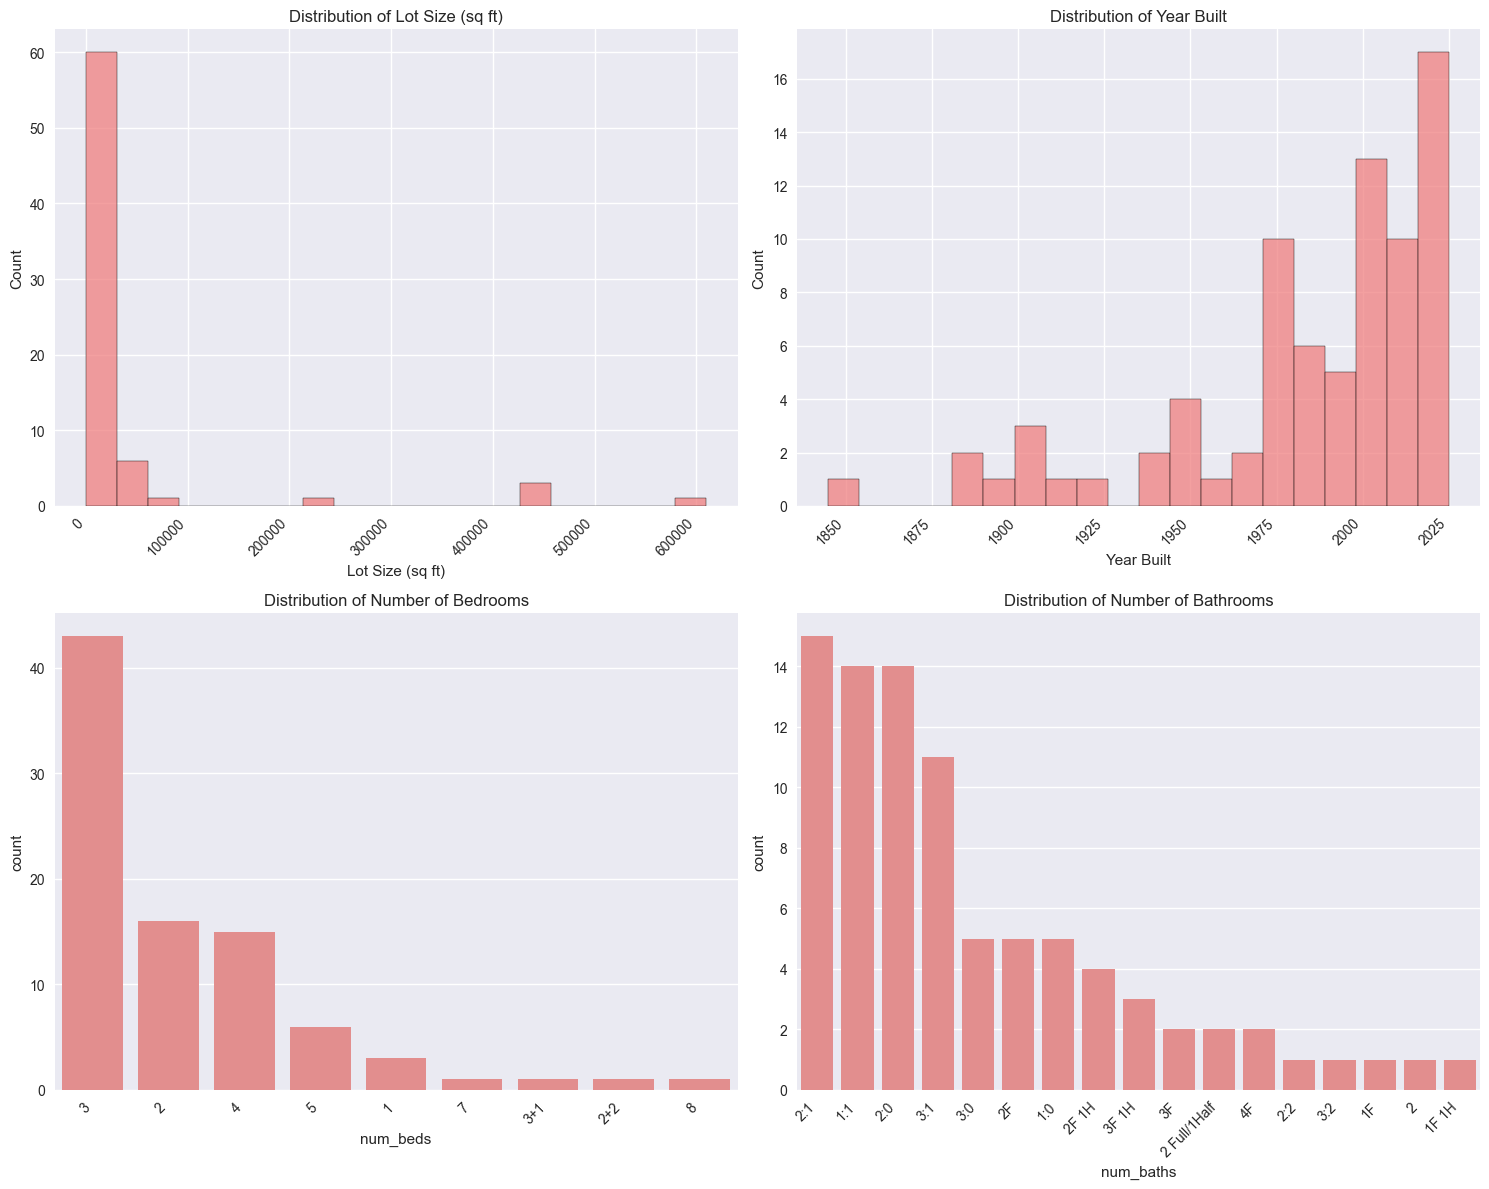

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribution of Lot Size (numeric only)
sns.histplot(data=subjects_df, x='lot_size_sf_clean', ax=axes[0,0], color='lightcoral', bins=20)
axes[0,0].set_title('Distribution of Lot Size (sq ft)')
axes[0,0].set_xlabel('Lot Size (sq ft)')

# Plot 2: Distribution of Year Built (numeric only)
sns.histplot(data=subjects_df, x='year_built_num', ax=axes[0,1], color='lightcoral', bins=20)
axes[0,1].set_title('Distribution of Year Built')
axes[0,1].set_xlabel('Year Built')

# Plot 3: Distribution of Number of Bedrooms
sns.countplot(data=subjects_df, x='num_beds', ax=axes[1,0], color='lightcoral',
              order=subjects_df['num_beds'].value_counts().index)
axes[1,0].set_title('Distribution of Number of Bedrooms')
axes[1,0].set_xlabel('num_beds')

# Plot 4: Distribution of Number of Bathrooms
sns.countplot(data=subjects_df, x='num_baths', ax=axes[1,1], color='lightcoral',
              order=subjects_df['num_baths'].value_counts().index)
axes[1,1].set_title('Distribution of Number of Bathrooms')
axes[1,1].set_xlabel('num_baths')

# Rotate x-axis labels for all plots
for ax in axes.flat:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [53]:
for val in subjects_df['lot_size_sf'].head(20):
    s = str(val).lower()
    match = re.search(r'([\d,.]+)', s)
    print(f"Raw: {val} | Match: {match.group(1) if match else None}")

Raw: n/a | Match: None
Raw: 72745+/-SqFt | Match: 72745
Raw: 20174 SqFt | Match: 20174
Raw: 1.25 Acres | Match: 1.25
Raw: N/A | Match: None
Raw: 6825 SqFt | Match: 6825
Raw: 3694 SqFt | Match: 3694
Raw: 3358 SqFt | Match: 3358
Raw: N/A | Match: None
Raw: 549 SqM | Match: 549
Raw: 42495 SqFt | Match: 42495
Raw: 2619 SqFt | Match: 2619
Raw: 26700 SqFt | Match: 26700
Raw: 5,663 SqFt | Match: 5,663
Raw: 33943+/-SqFt | Match: 33943
Raw: 5987 SqFt | Match: 5987
Raw: 10.057 Acres | Match: 10.057
Raw: 1742 SqFt | Match: 1742
Raw: 3250 SqFt | Match: 3250
Raw: 377 SqM | Match: 377


Feature Engineering

In [54]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Select features
categorical_features = ['structure_type', 'style', 'heating']
numeric_features = ['gla', 'year_built', 'lot_size_sf_clean', 'num_beds', 'num_baths', 'room_count']

# Convert to numeric where possible
subjects_df['num_beds'] = pd.to_numeric(subjects_df['num_beds'], errors='coerce')
subjects_df['num_baths'] = pd.to_numeric(subjects_df['num_baths'], errors='coerce')
subjects_df['year_built'] = pd.to_numeric(subjects_df['year_built'], errors='coerce')
subjects_df['gla'] = pd.to_numeric(subjects_df['gla'], errors='coerce')
subjects_df['room_count'] = pd.to_numeric(subjects_df['room_count'], errors='coerce')

# Handle missing values and encode features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X = preprocessor.fit_transform(subjects_df)
print('Feature matrix shape:', X.shape)

Feature matrix shape: (88, 46)


In [55]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute pairwise distances
distances = euclidean_distances(X, X)

# For each property, find the 3 most similar (excluding itself)
top_k = 3
top_similar_indices = distances.argsort(axis=1)[:, 1:top_k+1]
print('Indices of top 3 similar properties for the first subject:', top_similar_indices[0])

Indices of top 3 similar properties for the first subject: [66 55 25]


In [56]:
# Example: Show feature differences for the first subject and its top comp
subject_idx = 0
for comp_idx in top_similar_indices[subject_idx]:
    print(f"\nSubject vs. Comp {comp_idx}:")
    diffs = (subjects_df.iloc[subject_idx][numeric_features] - subjects_df.iloc[comp_idx][numeric_features]).abs()
    print('Feature differences:')
    print(diffs.sort_values())
    # You can add more explainability logic here (e.g., SHAP, LIME, or custom rules)


Subject vs. Comp 66:
Feature differences:
num_beds             0.0
room_count           0.0
year_built           1.0
gla                  NaN
lot_size_sf_clean    NaN
num_baths            NaN
dtype: object

Subject vs. Comp 55:
Feature differences:
num_beds             0.0
room_count           0.0
gla                  NaN
year_built           NaN
lot_size_sf_clean    NaN
num_baths            NaN
dtype: object

Subject vs. Comp 25:
Feature differences:
num_beds              0.0
room_count            0.0
year_built           40.0
gla                   NaN
lot_size_sf_clean     NaN
num_baths             NaN
dtype: object


Evaluation

In [57]:
print(subjects_df.columns.tolist())

['address', 'subject_city_province_zip', 'effective_date', 'municipality_district', 'site_dimensions', 'lot_size_sf', 'units_sq_ft', 'year_built', 'structure_type', 'roofing', 'effective_age', 'style', 'construction', 'remaining_economic_life', 'windows', 'basement', 'exterior_finish', 'basement_area', 'foundation_walls', 'flooring', 'plumbing_lines', 'heating', 'fuel_type', 'water_heater', 'cooling', 'room_count', 'num_beds', 'room_total', 'main_lvl_area', 'second_lvl_area', 'third_lvl_area', 'gla', 'subject_age', 'num_baths', 'condition', 'lot_size_sf_clean', 'year_built_num']


In [58]:
print(appraisals_df['appraisals'].iloc[0]['comps'])

[{'distance_to_subject': '0.15 KM', 'prop_type': 'Townhouse', 'stories': '2 Storey', 'address': '930 Amberdale Cres', 'city_province': 'Kingston ON K7M 6V1', 'sale_date': 'Oct/25/2024', 'sale_price': '378,900', 'dom': '38', 'location_similarity': 'Similar', 'lot_size': 'N/A Condominium', 'age': '49', 'condition': 'Superior', 'gla': '1044 SqFt', 'room_count': '6', 'bed_count': '3', 'bath_count': '2:0', 'basement_finish': 'Full/Finished', 'parking': 'No Garage', 'neighborhood': ''}, {'distance_to_subject': '0.02 KM', 'prop_type': 'Townhouse', 'stories': '2 Storey', 'address': '771 Ashwood Dr', 'city_province': 'Kingston ON K7M 6X7', 'sale_date': 'Feb/05/2025', 'sale_price': '327,000', 'dom': '51', 'location_similarity': 'Inferior', 'lot_size': 'N/A Condominium', 'age': '49', 'condition': 'Inferior', 'gla': '1044 SqFt', 'room_count': '6', 'bed_count': '3', 'bath_count': '1:0', 'basement_finish': 'Full/Finished', 'parking': 'No Garage', 'neighborhood': ''}, {'distance_to_subject': '0.09 KM

In [59]:
ground_truth_comps = appraisals_df['appraisals'].apply(lambda x: [comp['address'] for comp in x['comps']])

In [60]:
subject_ids = subjects_df['address'].tolist()

In [61]:
correct_counts = []
for i, indices in enumerate(top_similar_indices):
    recommended_addresses = [subject_ids[j] for j in indices]
    true_comps = set(ground_truth_comps.iloc[i])
    correct = sum([addr in true_comps for addr in recommended_addresses])
    correct_counts.append(correct)

# Calculate average precision@3
precision_at_3 = sum(correct_counts) / (len(correct_counts) * 3)
print(f"Average Precision@3: {precision_at_3:.2f}")

Average Precision@3: 0.00


In [62]:
all_comp_addresses = set(addr for comp_list in ground_truth_comps for addr in comp_list)
subject_addresses = set(subject_ids)
overlap = all_comp_addresses & subject_addresses
print(f"Number of comp addresses in subject addresses: {len(overlap)}")
print("Example overlap addresses:", list(overlap)[:5])

Number of comp addresses in subject addresses: 0
Example overlap addresses: []


In [63]:
# Flatten all candidate properties into a single DataFrame
all_candidates = []
for appraisal in appraisals_df['appraisals']:
    for prop in appraisal.get('properties', []):
        all_candidates.append(prop)
candidates_df = pd.DataFrame(all_candidates)

print(candidates_df.columns)
print(candidates_df.head())

Index(['id', 'address', 'bedrooms', 'gla', 'city', 'province', 'postal_code',
       'property_sub_type', 'structure_type', 'style', 'levels', 'room_count',
       'full_baths', 'half_baths', 'main_level_finished_area',
       'upper_lvl_fin_area', 'bg_fin_area', 'lot_size_sf', 'year_built',
       'roof', 'basement', 'cooling', 'heating', 'close_price', 'close_date',
       'public_remarks', 'latitude', 'longitude'],
      dtype='object')
       id                  address  bedrooms     gla       city province  \
0     367      463 Conservatory Dr       3.0  1500.0   Kingston  Ontario   
1  163443  463 Conservatory Drive        3.0  1750.0  Kingston   Ontario   
2     378           311 Janette St       3.0  1500.0   Kingston  Ontario   
3  130023      311 Janette Street        3.0  1300.0  Kingston   Ontario   
4    2782             4056 Bath Rd       4.0     NaN   Kingston  Ontario   

  postal_code   property_sub_type                 structure_type  \
0     K7M 9C8            Detach

In [64]:
candidate_addresses = set(candidates_df['address'])
overlap = all_comp_addresses & candidate_addresses
print(f"Number of comp addresses in candidate addresses: {len(overlap)}")
print("Example overlap addresses:", list(overlap)[:5])

Number of comp addresses in candidate addresses: 7
Example overlap addresses: ['6547 Highway 7', '20 Creekside Way', '283 Falsetto St', '2282 Descartes St', '46 York St']


In [65]:
from sklearn.preprocessing import StandardScaler

precision_scores = []

for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    comps = [comp['address'] for comp in appraisal.get('comps', [])]
    
    # Build DataFrame for candidates
    candidates_df = pd.DataFrame(candidates)
    if candidates_df.empty:
        continue
    
    # Add the subject as the first row
    subject_df = pd.DataFrame([subject])
    all_df = pd.concat([subject_df, candidates_df], ignore_index=True)
    
    # Select and clean features (adjust as needed)
    # ... previous code ...
# Select and clean features (adjust as needed)
    features = ['bedrooms', 'gla', 'year_built', 'lot_size_sf', 'structure_type']
    for f in ['bedrooms', 'gla', 'year_built', 'lot_size_sf']:
        all_df[f] = pd.to_numeric(all_df[f], errors='coerce')
    all_df = all_df.fillna(0)

    # Encode categorical
    all_df = pd.get_dummies(all_df, columns=['structure_type'], drop_first=True)

    # Only keep numeric columns for similarity
    numeric_cols = all_df.select_dtypes(include=[float, int]).columns
    X = all_df[numeric_cols].values

    # Standardize numeric
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Compute distances from subject (row 0) to all candidates
    dists = ((X_scaled[1:] - X_scaled[0])**2).sum(axis=1)
    top_k_idx = dists.argsort()[:3]
    recommended_addresses = candidates_df.iloc[top_k_idx]['address'].tolist()
    
    # Precision@3 for this appraisal
    correct = sum([addr in comps for addr in recommended_addresses])
    precision_scores.append(correct / 3)

# Overall average precision@3
print(f"Average Precision@3: {sum(precision_scores)/len(precision_scores):.2f}")

/var/folders/9k/7jlq1bl52hl_xbvghjcpcws40000gn/T/ipykernel_23698/398057460.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df = all_df.fillna(0)
/var/folders/9k/7jlq1bl52hl_xbvghjcpcws40000gn/T/ipykernel_23698/398057460.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df = all_df.fillna(0)
/var/folders/9k/7jlq1bl52hl_xbvghjcpcws40000gn/T/ipykernel_23698/398057460.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

Average Precision@3: 0.00


/var/folders/9k/7jlq1bl52hl_xbvghjcpcws40000gn/T/ipykernel_23698/398057460.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df = all_df.fillna(0)
/var/folders/9k/7jlq1bl52hl_xbvghjcpcws40000gn/T/ipykernel_23698/398057460.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df = all_df.fillna(0)
/var/folders/9k/7jlq1bl52hl_xbvghjcpcws40000gn/T/ipykernel_23698/398057460.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

In [66]:
all_df = all_df.fillna(0, downcast='infer')

/var/folders/9k/7jlq1bl52hl_xbvghjcpcws40000gn/T/ipykernel_23698/4020584611.py:1: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  all_df = all_df.fillna(0, downcast='infer')


In [71]:
print("Sample subject_ids:", subject_ids[:5])
print("Sample ground_truth_comps:", ground_truth_comps.iloc[0])
print("Sample recommended_addresses:", recommended_addresses)

Sample subject_ids: ['142-950 oakview ave kingston on k7m 6w8', '7180 207 hwy halifax ns b0j2l0', '11 paul ave ayr on n0b1e0', '102 stonewalk dr kemptville on k0g 1j0', '407 105 dunbrack st halifax ns b3m3g7']
Sample ground_truth_comps: ['930 amberdale cres', '771 ashwood dr', '995 amberdale cres']
Sample recommended_addresses: ['2738 isle of man road', '1984 downsview drive', '1220 cyprus rd']


In [72]:
def clean_id(addr):
    return str(addr).strip().lower()

subject_ids = [clean_id(x) for x in subject_ids]
ground_truth_comps = ground_truth_comps.apply(lambda comp_list: [clean_id(addr) for addr in comp_list])
# Also clean recommended_addresses before comparison
recommended_addresses = [clean_id(addr) for addr in recommended_addresses]

In [73]:
correct_counts = []
for i, indices in enumerate(top_similar_indices):
    recommended_addresses = [subject_ids[j] for j in indices]
    true_comps = set(ground_truth_comps.iloc[i])
    correct = sum([addr in true_comps for addr in recommended_addresses])
    correct_counts.append(correct)

# Calculate average precision@3
precision_at_3 = sum(correct_counts) / (len(correct_counts) * 3)
print(f"Average Precision@3: {precision_at_3:.2f}")

Average Precision@3: 0.00


In [74]:
for i, indices in enumerate(top_similar_indices):
    recommended_addresses = [clean_id(subject_ids[j]) for j in indices]
    true_comps = set([clean_id(addr) for addr in ground_truth_comps.iloc[i]])
    print(f"\nSubject {i}:")
    print("Recommended:", recommended_addresses)
    print("True comps:", true_comps)
    print("Overlap:", set(recommended_addresses) & true_comps)
    correct = sum(addr in true_comps for addr in recommended_addresses)
    correct_counts.append(correct)


Subject 0:
Recommended: ['84 carleton pl brampton on l6t3z4', '194 calvington ave ottawa on k2t0h9', '340 axis way ottawa on k1w 0j9']
True comps: {'995 amberdale cres', '930 amberdale cres', '771 ashwood dr'}
Overlap: set()

Subject 1:
Recommended: ['70 cliffview lane head of jeddore ns b0j1p0', '3 bayview lane queensland ns b0j1t0', '1753 reginald bart dr kingston on k7k0e9']
True comps: {'64 deermist dr', '85 oceanic dr', '270 quinlan dr'}
Overlap: set()

Subject 2:
Recommended: ['2 rockcliff hts nw calgary ab t3g0c7', '5 lewiston rd ne calgary ab t3p 2j3', '531 des genévriers rue orléans on k4a0z2']
True comps: {'3219 roseville rd', '6 marshall ave', '13 james crt'}
Overlap: set()

Subject 3:
Recommended: ['3666 douglas woods hts se calgary ab t2z2g4', '84339 kent line brussels on n0g1h0', '824 9a st ne calgary ab t2e4l6']
True comps: {'36 stonewalk dr', '56 stonewalk dr', '48 stonewalk dr'}
Overlap: set()

Subject 4:
Recommended: ['401 540 talbot pl gananoque on k7g3c6', '306 11 

In [75]:
def clean_id(addr):
    return str(addr).strip().lower()

correct_counts = []
for i, indices in enumerate(top_similar_indices):
    # Clean recommended addresses for this subject
    recommended_addresses = [clean_id(subject_ids[j]) for j in indices]
    # Clean true comps for this subject
    true_comps = set([clean_id(addr) for addr in ground_truth_comps.iloc[i]])
    
    # Debug print
    print(f"\nSubject {i}:")
    print("Recommended:", recommended_addresses)
    print("True comps:", true_comps)
    print("Overlap:", set(recommended_addresses) & true_comps)
    
    correct = sum(addr in true_comps for addr in recommended_addresses)
    correct_counts.append(correct)

precision_at_3 = sum(correct_counts) / (len(correct_counts) * 3)
print(f"Average Precision@3: {precision_at_3:.2f}")


Subject 0:
Recommended: ['84 carleton pl brampton on l6t3z4', '194 calvington ave ottawa on k2t0h9', '340 axis way ottawa on k1w 0j9']
True comps: {'995 amberdale cres', '930 amberdale cres', '771 ashwood dr'}
Overlap: set()

Subject 1:
Recommended: ['70 cliffview lane head of jeddore ns b0j1p0', '3 bayview lane queensland ns b0j1t0', '1753 reginald bart dr kingston on k7k0e9']
True comps: {'64 deermist dr', '85 oceanic dr', '270 quinlan dr'}
Overlap: set()

Subject 2:
Recommended: ['2 rockcliff hts nw calgary ab t3g0c7', '5 lewiston rd ne calgary ab t3p 2j3', '531 des genévriers rue orléans on k4a0z2']
True comps: {'3219 roseville rd', '6 marshall ave', '13 james crt'}
Overlap: set()

Subject 3:
Recommended: ['3666 douglas woods hts se calgary ab t2z2g4', '84339 kent line brussels on n0g1h0', '824 9a st ne calgary ab t2e4l6']
True comps: {'36 stonewalk dr', '56 stonewalk dr', '48 stonewalk dr'}
Overlap: set()

Subject 4:
Recommended: ['401 540 talbot pl gananoque on k7g3c6', '306 11 

In [76]:
def clean_id(addr):
    return str(addr).strip().lower()

precision_scores = []

for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    
    # Get addresses for ground truth comps
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    
    # Your model should recommend top 3 from candidates for this subject
    # For now, let's just use a placeholder: pick 3 random candidates
    # Replace this with your actual recommendation logic!
    import random
    if len(candidates) < 3:
        continue
    recommended = random.sample(candidates, 3)
    recommended_addresses = [clean_id(comp['address']) for comp in recommended]
    
    # Debug print
    print(f"\nAppraisal {idx}:")
    print("Recommended:", recommended_addresses)
    print("True comps:", true_comps)
    print("Overlap:", set(recommended_addresses) & true_comps)
    
    correct = sum(addr in true_comps for addr in recommended_addresses)
    precision_scores.append(correct / 3)

# Calculate average precision@3
if precision_scores:
    avg_precision_at_3 = sum(precision_scores) / len(precision_scores)
    print(f"\nAverage Precision@3: {avg_precision_at_3:.2f}")
else:
    print("No appraisals with enough candidates to evaluate.")


Appraisal 0:
Recommended: ['1040 earnhart st', '995 amberdale crescent', '792 safari dr']
True comps: {'995 amberdale cres', '930 amberdale cres', '771 ashwood dr'}
Overlap: set()

Appraisal 1:
Recommended: ['15 macdonald lane', '46 ostrea lake road', '205 east petpeswick road, musquodoboit harbour']
True comps: {'64 deermist dr', '85 oceanic dr', '270 quinlan dr'}
Overlap: set()

Appraisal 2:
Recommended: ['931 stonecliffe walk', '94 sophia crescent', 'unit h - 29 sienna street']
True comps: {'3219 roseville rd', '6 marshall ave', '13 james crt'}
Overlap: set()

Appraisal 3:
Recommended: ['221 douglas hardie street', '169 robert perry street', '138 tradewinds crescent']
True comps: {'36 stonewalk dr', '56 stonewalk dr', '48 stonewalk dr'}
Overlap: set()

Appraisal 4:
Recommended: ['unit 801 105 dunbrack street', '33 stratford way', '170 st. andrews street']
True comps: {'313-79 bedros lane', '210-40 regency park dr', '801-105 dunbrack st'}
Overlap: set()

Appraisal 5:
Recommended: ['

In [77]:
import numpy as np

def get_features(prop):
    # Extract GLA and year_built, handle missing values
    try:
        gla = float(str(prop.get('gla', 0)).replace('SqFt', '').strip() or 0)
    except:
        gla = 0
    try:
        year_built = float(prop.get('year_built', 0) or 0)
    except:
        year_built = 0
    return [gla, year_built]

def recommend_top3(subject, candidates):
    subject_feat = np.array(get_features(subject))
    candidate_feats = np.array([get_features(c) for c in candidates])
    # Compute Euclidean distance
    dists = np.linalg.norm(candidate_feats - subject_feat, axis=1)
    top3_idx = np.argsort(dists)[:3]
    return [candidates[i] for i in top3_idx]

precision_scores = []
for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    if len(candidates) < 3:
        continue
    recommended = recommend_top3(subject, candidates)
    recommended_addresses = [clean_id(comp['address']) for comp in recommended]
    overlap = set(recommended_addresses) & true_comps
    print(f"\nAppraisal {idx}:")
    print("Recommended:", recommended_addresses)
    print("True comps:", true_comps)
    print("Overlap:", overlap)
    correct = sum(addr in true_comps for addr in recommended_addresses)
    precision_scores.append(correct / 3)

if precision_scores:
    avg_precision_at_3 = sum(precision_scores) / len(precision_scores)
    print(f"\nAverage Precision@3 (Similarity-based): {avg_precision_at_3:.2f}")
else:
    print("No appraisals with enough candidates to evaluate.")


Appraisal 0:
Recommended: ['995 amberdale cres', '771 ashwood dr', '760 grouse cres']
True comps: {'995 amberdale cres', '930 amberdale cres', '771 ashwood dr'}
Overlap: {'771 ashwood dr', '995 amberdale cres'}

Appraisal 1:
Recommended: ['8426 highway 7', '569 west jeddore road', '2 willowdale drive']
True comps: {'64 deermist dr', '85 oceanic dr', '270 quinlan dr'}
Overlap: set()

Appraisal 2:
Recommended: ['299 moorlands crescent', '2259 cedar creek road', '182 doon mills drive']
True comps: {'3219 roseville rd', '6 marshall ave', '13 james crt'}
Overlap: set()

Appraisal 3:
Recommended: ['306 fir lane', '935 county 44 road', '326 jack street']
True comps: {'36 stonewalk dr', '56 stonewalk dr', '48 stonewalk dr'}
Overlap: set()

Appraisal 4:
Recommended: ['30 stratford way', 'unit 210 40 regency park drive', 'unit 503 78 regency park drive']
True comps: {'313-79 bedros lane', '210-40 regency park dr', '801-105 dunbrack st'}
Overlap: set()

Appraisal 5:
Recommended: ['64 amethyst cr

In [78]:
import numpy as np

def get_features(prop):
    # Extract and clean features, handle missing values
    def to_float(val):
        try:
            return float(str(val).replace('SqFt', '').replace(',', '').strip() or 0)
        except:
            return 0
    gla = to_float(prop.get('gla', 0))
    year_built = to_float(prop.get('year_built', 0))
    lot_size = to_float(prop.get('lot_size_sf', 0))
    num_beds = to_float(prop.get('num_beds', 0))
    num_baths = to_float(prop.get('num_baths', 0))
    # Add more features as needed
    return [gla, year_built, lot_size, num_beds, num_baths]

def recommend_top3(subject, candidates):
    subject_feat = np.array(get_features(subject))
    candidate_feats = np.array([get_features(c) for c in candidates])
    # Standardize features
    means = candidate_feats.mean(axis=0)
    stds = candidate_feats.std(axis=0) + 1e-6
    subject_feat = (subject_feat - means) / stds
    candidate_feats = (candidate_feats - means) / stds
    # Compute Euclidean distance
    dists = np.linalg.norm(candidate_feats - subject_feat, axis=1)
    top3_idx = np.argsort(dists)[:3]
    return [candidates[i] for i in top3_idx]

# Re-run the evaluation loop as before
precision_scores = []
for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    if len(candidates) < 3:
        continue
    recommended = recommend_top3(subject, candidates)
    recommended_addresses = [clean_id(comp['address']) for comp in recommended]
    overlap = set(recommended_addresses) & true_comps
    print(f"\nAppraisal {idx}:")
    print("Recommended:", recommended_addresses)
    print("True comps:", true_comps)
    print("Overlap:", overlap)
    correct = sum(addr in true_comps for addr in recommended_addresses)
    precision_scores.append(correct / 3)

if precision_scores:
    avg_precision_at_3 = sum(precision_scores) / len(precision_scores)
    print(f"\nAverage Precision@3 (Multi-feature): {avg_precision_at_3:.2f}")
else:
    print("No appraisals with enough candidates to evaluate.")


Appraisal 0:
Recommended: ['unit 108 - 835 milford dr', '4061 bath rd', '995 amberdale cres']
True comps: {'995 amberdale cres', '930 amberdale cres', '771 ashwood dr'}
Overlap: {'995 amberdale cres'}

Appraisal 1:
Recommended: ['6547 highway 7', '8426 highway 7', '6820 highway 7']
True comps: {'64 deermist dr', '85 oceanic dr', '270 quinlan dr'}
Overlap: set()

Appraisal 2:
Recommended: ['967 doon village road', '60 cedar crescent', '3219 roseville road']
True comps: {'3219 roseville rd', '6 marshall ave', '13 james crt'}
Overlap: set()

Appraisal 3:
Recommended: ['306 fir lane', '302 fir lane', '503 george street e']
True comps: {'36 stonewalk dr', '56 stonewalk dr', '48 stonewalk dr'}
Overlap: set()

Appraisal 4:
Recommended: ['unit 210 40 regency park drive', 'unit 503 78 regency park drive', 'unit 105 10 regency park drive']
True comps: {'313-79 bedros lane', '210-40 regency park dr', '801-105 dunbrack st'}
Overlap: set()

Appraisal 5:
Recommended: ['284 colby drive', '164 silist

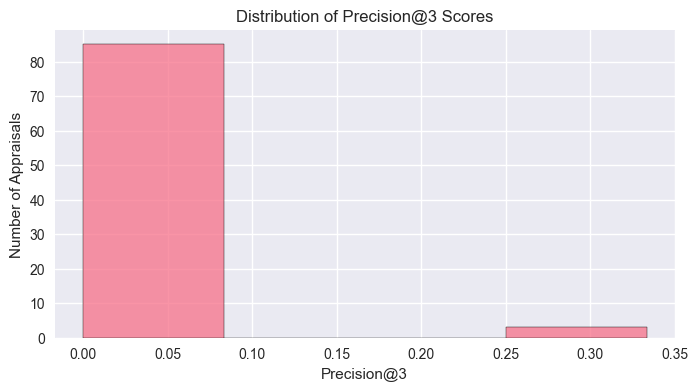

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(precision_scores, bins=4, kde=False)
plt.title('Distribution of Precision@3 Scores')
plt.xlabel('Precision@3')
plt.ylabel('Number of Appraisals')
plt.show()

In [80]:
# Show a few examples where the model succeeded (overlap > 0) and failed (overlap == 0)
for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    if len(candidates) < 3:
        continue
    recommended = recommend_top3(subject, candidates)
    recommended_addresses = [clean_id(comp['address']) for comp in recommended]
    overlap = set(recommended_addresses) & true_comps
    if overlap:
        print(f"SUCCESS Appraisal {idx}: Overlap {overlap}")
        print("Recommended:", recommended_addresses)
        print("True comps:", true_comps)
        break

for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    if len(candidates) < 3:
        continue
    recommended = recommend_top3(subject, candidates)
    recommended_addresses = [clean_id(comp['address']) for comp in recommended]
    overlap = set(recommended_addresses) & true_comps
    if not overlap:
        print(f"FAILURE Appraisal {idx}: No overlap")
        print("Recommended:", recommended_addresses)
        print("True comps:", true_comps)
        break

SUCCESS Appraisal 0: Overlap {'995 amberdale cres'}
Recommended: ['unit 108 - 835 milford dr', '4061 bath rd', '995 amberdale cres']
True comps: {'995 amberdale cres', '930 amberdale cres', '771 ashwood dr'}
FAILURE Appraisal 1: No overlap
Recommended: ['6547 highway 7', '8426 highway 7', '6820 highway 7']
True comps: {'64 deermist dr', '85 oceanic dr', '270 quinlan dr'}


In [82]:
from geopy.distance import geodesic
import numpy as np

def to_float(val):
    try:
        return float(str(val).replace('SqFt', '').replace(',', '').strip() or 0)
    except:
        return 0

def get_features(prop, subject=None):
    gla = to_float(prop.get('gla', 0))
    year_built = to_float(prop.get('year_built', 0))
    lot_size = to_float(prop.get('lot_size_sf', 0))
    num_beds = to_float(prop.get('num_beds', 0))
    num_baths = to_float(prop.get('num_baths', 0))
    # Location distance (in km)
    if subject is not None:
        try:
            lat = float(prop.get('latitude', 0) or 0)
            lon = float(prop.get('longitude', 0) or 0)
            subj_lat = float(subject.get('latitude', 0) or 0)
            subj_lon = float(subject.get('longitude', 0) or 0)
            if lat and lon and subj_lat and subj_lon:
                loc_dist = geodesic((lat, lon), (subj_lat, subj_lon)).km
            else:
                loc_dist = 0
        except:
            loc_dist = 0
    else:
        loc_dist = 0
    return [gla, year_built, lot_size, num_beds, num_baths, loc_dist]

def weighted_distance(a, b, weights):
    return np.sqrt(np.sum(weights * (a - b) ** 2))

# Example weights: [GLA, year_built, lot_size, beds, baths, loc_dist]
weights = np.array([2, 1, 1, 1, 1, 3])  # You can tune these

def recommend_top3(subject, candidates):
    subject_feat = np.array(get_features(subject))
    candidate_feats = np.array([get_features(c, subject) for c in candidates])
    # Standardize features
    means = candidate_feats.mean(axis=0)
    stds = candidate_feats.std(axis=0) + 1e-6
    subject_feat = (subject_feat - means) / stds
    candidate_feats = (candidate_feats - means) / stds
    # Compute weighted distance
    dists = np.array([weighted_distance(subject_feat, cf, weights) for cf in candidate_feats])
    top3_idx = np.argsort(dists)[:3]
    return [candidates[i] for i in top3_idx]

# Re-run the evaluation loop as before
precision_scores = []
for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    if len(candidates) < 3:
        continue
    recommended = recommend_top3(subject, candidates)
    recommended_addresses = [clean_id(comp['address']) for comp in recommended]
    overlap = set(recommended_addresses) & true_comps
    print(f"\nAppraisal {idx}:")
    print("Recommended:", recommended_addresses)
    print("True comps:", true_comps)
    print("Overlap:", overlap)
    correct = sum(addr in true_comps for addr in recommended_addresses)
    precision_scores.append(correct / 3)

if precision_scores:
    avg_precision_at_3 = sum(precision_scores) / len(precision_scores)
    print(f"\nAverage Precision@3 (Weighted + Location): {avg_precision_at_3:.2f}")
else:
    print("No appraisals with enough candidates to evaluate.")


Appraisal 0:
Recommended: ['unit 108 - 835 milford dr', '4061 bath rd', '995 amberdale cres']
True comps: {'995 amberdale cres', '930 amberdale cres', '771 ashwood dr'}
Overlap: {'995 amberdale cres'}

Appraisal 1:
Recommended: ['8426 highway 7', '6547 highway 7', '2 willowdale drive']
True comps: {'64 deermist dr', '85 oceanic dr', '270 quinlan dr'}
Overlap: set()

Appraisal 2:
Recommended: ['967 doon village road', '3219 roseville road', '27 rush meadow street']
True comps: {'3219 roseville rd', '6 marshall ave', '13 james crt'}
Overlap: set()

Appraisal 3:
Recommended: ['306 fir lane', '302 fir lane', '503 george street e']
True comps: {'36 stonewalk dr', '56 stonewalk dr', '48 stonewalk dr'}
Overlap: set()

Appraisal 4:
Recommended: ['unit 503 78 regency park drive', 'unit 210 40 regency park drive', 'unit 105 10 regency park drive']
True comps: {'313-79 bedros lane', '210-40 regency park dr', '801-105 dunbrack st'}
Overlap: set()

Appraisal 5:
Recommended: ['284 colby drive', '16

In [83]:
!pip install xgboost scikit-learn

python(40506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


     |████████████████████████████████| 2.1 MB 3.3 MB/s eta 0:00:01
You should consider upgrading via the '/Users/hishammaarraoui/Desktop/Property Recommendation System Project/venv/bin/python -m pip install --upgrade pip' command.


In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def to_float(val):
    try:
        return float(str(val).replace('SqFt', '').replace(',', '').strip() or 0)
    except:
        return 0

def extract_features(subject, candidate):
    # Numeric features
    gla_diff = abs(to_float(subject.get('gla', 0)) - to_float(candidate.get('gla', 0)))
    year_built_diff = abs(to_float(subject.get('year_built', 0)) - to_float(candidate.get('year_built', 0)))
    lot_size_diff = abs(to_float(subject.get('lot_size_sf', 0)) - to_float(candidate.get('lot_size_sf', 0)))
    num_beds_diff = abs(to_float(subject.get('num_beds', 0)) - to_float(candidate.get('num_beds', 0)))
    num_baths_diff = abs(to_float(subject.get('num_baths', 0)) - to_float(candidate.get('num_baths', 0)))
    # Categorical features (property type, style, etc.)
    prop_type_match = int(subject.get('structure_type', '') == candidate.get('structure_type', ''))
    return [gla_diff, year_built_diff, lot_size_diff, num_beds_diff, num_baths_diff, prop_type_match]

X = []
y = []

for appraisal in appraisals_df['appraisals']:
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    for candidate in candidates:
        features = extract_features(subject, candidate)
        label = int(clean_id(candidate['address']) in true_comps)
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)
print("Feature matrix shape:", X.shape)
print("Positive samples:", y.sum())

Feature matrix shape: (9820, 6)
Positive samples: 29


In [85]:
from sklearn.neighbors import NearestNeighbors

# For KNN, use the same features as above
precision_scores = []
for idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    if len(candidates) < 3:
        continue
    features = np.array([extract_features(subject, c) for c in candidates])
    # KNN: find 3 nearest neighbors (smallest feature difference)
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(features)
    subject_feat = np.array([extract_features(subject, subject)])
    distances, indices = nbrs.kneighbors(subject_feat)
    top3_idx = indices[0]
    recommended_addresses = [clean_id(candidates[i]['address']) for i in top3_idx]
    overlap = set(recommended_addresses) & true_comps
    correct = sum(addr in true_comps for addr in recommended_addresses)
    precision_scores.append(correct / 3)

if precision_scores:
    avg_precision_at_3 = sum(precision_scores) / len(precision_scores)
    print(f"\nAverage Precision@3 (KNN): {avg_precision_at_3:.2f}")
else:
    print("No appraisals with enough candidates to evaluate.")


Average Precision@3 (KNN): 0.02


python(40598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [92]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Prepare the labeled dataset as before
X = []
y = []
meta = []  # To keep track of which appraisal/candidate each row belongs to

for appraisal_idx, appraisal in enumerate(appraisals_df['appraisals']):
    subject = appraisal['subject']
    candidates = appraisal.get('properties', [])
    ground_truth_comps = appraisal.get('comps', [])
    true_comps = set([clean_id(comp['address']) for comp in ground_truth_comps])
    for candidate_idx, candidate in enumerate(candidates):
        features = extract_features(subject, candidate)
        label = int(clean_id(candidate['address']) in true_comps)
        X.append(features)
        y.append(label)
        meta.append((appraisal_idx, candidate_idx))

X = np.array(X)
y = np.array(y)
meta = np.array(meta)

# Split into train/val
X_train, X_val, y_train, y_val, meta_train, meta_val = train_test_split(
    X, y, meta, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluate on validation set, grouped by appraisal
import collections
val_appraisal_to_candidates = collections.defaultdict(list)
val_appraisal_to_true_comps = collections.defaultdict(set)

for i, (appraisal_idx, candidate_idx) in enumerate(meta_val):
    val_appraisal_to_candidates[appraisal_idx].append((i, candidate_idx))

# Build a mapping from appraisal_idx to ground truth comps
for appraisal_idx in val_appraisal_to_candidates:
    appraisal = appraisals_df['appraisals'][appraisal_idx]
    ground_truth_comps = appraisal.get('comps', [])
    val_appraisal_to_true_comps[appraisal_idx] = set([clean_id(comp['address']) for comp in ground_truth_comps])

precision_scores = []
for appraisal_idx, candidates_info in val_appraisal_to_candidates.items():
    if len(candidates_info) < 3:
        continue
    # Get model probabilities for all candidates in this appraisal
    indices = [i for i, _ in candidates_info]
    candidate_indices = [candidate_idx for _, candidate_idx in candidates_info]
    probs = model.predict_proba(X_val[indices])[:, 1]
    # Get top 3 candidates by probability
    top3_idx = np.argsort(probs)[-3:][::-1]
    appraisal = appraisals_df['appraisals'][appraisal_idx]
    candidates = appraisal.get('properties', [])
    recommended_addresses = [clean_id(candidates[candidate_indices[i]]['address']) for i in top3_idx]
    true_comps = val_appraisal_to_true_comps[appraisal_idx]
    overlap = set(recommended_addresses) & true_comps
    correct = sum(addr in true_comps for addr in recommended_addresses)
    precision_scores.append(correct / 3)

if precision_scores:
    avg_precision_at_3 = sum(precision_scores) / len(precision_scores)
    print(f"\nAverage Precision@3 (XGBoost, validation set): {avg_precision_at_3:.2f}")
else:
    print("No appraisals with enough candidates to evaluate.")

SyntaxError: positional argument follows keyword argument (569607027.py, line 31)